In [1]:
import os
import json
import numpy as np
import trimesh

In [2]:
def robust_floor_z(all_vertices:np.ndarray,percentile:float = 1.0) -> float:
    z = all_vertices[:, 2]
    return float(np.percentile(z, percentile))

In [3]:
def aabb_from_mesh_world(mesh: trimesh.Trimesh, transform: np.ndarray) -> dict:
    bmin, bmax = mesh.bounds
    corners = np.array([
        [bmin[0], bmin[1], bmin[2], 1.0],
        [bmin[0], bmin[1], bmax[2], 1.0],
        [bmin[0], bmax[1], bmin[2], 1.0],
        [bmin[0], bmax[1], bmax[2], 1.0],
        [bmax[0], bmin[1], bmin[2], 1.0],
        [bmax[0], bmin[1], bmax[2], 1.0],
        [bmax[0], bmax[1], bmin[2], 1.0],
        [bmax[0], bmax[1], bmax[2], 1.0],
    ], dtype=np.float64)

    world = (transform @ corners.T).T[:, :3]
    wmin = world.min(axis=0)
    wmax = world.max(axis=0)

    center = (wmin + wmax) / 2.0
    size = (wmax - wmin)

    return {
        "aabb_min": wmin.tolist(),
        "aabb_max": wmax.tolist(),
        "center": center.tolist(),
        "size": size.tolist(),
    }

In [12]:
def build_occupancy_grid(objects, room_bounds, floor_z, cell_size=0.25, floor_eps=0.12):
    room_min, room_max = room_bounds
    xmin, ymin, _ = room_min
    xmax, ymax, _ = room_max

    width = xmax - xmin
    height = ymax - ymin

    nx = int(np.ceil(width / cell_size))
    ny = int(np.ceil(height / cell_size))

    if nx <= 0 or ny <= 0:
        return {
            "cell_size": float(cell_size),
            "origin_xy": [float(xmin), float(ymin)],
            "shape": [0, 0],
            "data_rle": []
        }

    grid = np.zeros((ny, nx), dtype=np.uint8)

    def xy_to_ij(x, y):
        j = int((x - xmin) / cell_size)
        i = int((y - ymin) / cell_size)
        return i, j

    for obj in objects:
        aabb_min = np.array(obj["aabb_min"], dtype=float)
        aabb_max = np.array(obj["aabb_max"], dtype=float)

        # only obstacles near the floor matter for occupancy
        if aabb_min[2] > floor_z + floor_eps:
            continue

        x0, y0 = aabb_min[0], aabb_min[1]
        x1, y1 = aabb_max[0], aabb_max[1]

        i0, j0 = xy_to_ij(x0, y0)
        i1, j1 = xy_to_ij(x1, y1)

        # clamp
        i0 = max(0, min(ny - 1, i0))
        i1 = max(0, min(ny - 1, i1))
        j0 = max(0, min(nx - 1, j0))
        j1 = max(0, min(nx - 1, j1))

        r0, r1 = sorted([i0, i1])
        c0, c1 = sorted([j0, j1])

        grid[r0:r1 + 1, c0:c1 + 1] = 1

    return {
        "cell_size": float(cell_size),
        "origin_xy": [float(xmin), float(ymin)],
        "shape": [int(ny), int(nx)],
        "data_rle": rle_encode(grid)
    }

In [5]:
def xy_to_ij(x, y):
    j = int((x - xmin) / cell_size)
    i = int((y - ymin) / cell_size)
    return i, j

    for obj in objects:
        aabb_min = np.array(obj["aabb_min"], dtype=np.float64)
        aabb_max = np.array(obj["aabb_max"], dtype=np.float64)

        if aabb_min[2] > floor_z + 0.15:
            continue
        if (aabb_max[2] - floor_z) > z_filter_height:
            pass

        x0, y0 = aabb_min[0], aabb_min[1]
        x1, y1 = aabb_max[0], aabb_max[1]

        i0, j0 = xy_to_ij(x0, y0)
        i1, j1 = xy_to_ij(x1, y1)

        i0 = max(0, min(ny - 1, i0))
        i1 = max(0, min(ny - 1, i1))
        j0 = max(0, min(nx - 1, j0))
        j1 = max(0, min(nx - 1, j1))

        grid[min(i0, i1):max(i0, i1) + 1, min(j0, j1):max(j0, j1) + 1] = 1

    return {
        "cell_size": float(cell_size),
        "origin_xy": [float(xmin), float(ymin)],
        "shape": [int(ny), int(nx)],
        "data_rle": rle_encode(grid)  
    }

In [13]:
def rle_encode(grid: np.ndarray):
    flat = grid.reshape(-1)
    if flat.size == 0:
        return []
    out = []
    prev = int(flat[0])
    count = 1
    for v in flat[1:]:
        v = int(v)
        if v == prev:
            count += 1
        else:
            out.append([prev, count])
            prev = v
            count = 1
    out.append([prev, count])
    return out

In [14]:
import numpy as np

def tag_objects_phase15(objects, room_min, room_max, floor_z,
                        floor_eps=0.12,
                        struct_area_ratio=0.45,
                        struct_span_ratio=0.85,
                        obstacle_min_area=0.04,
                        clutter_max_area=0.01,
                        max_obstacle_height=3.0):
    
    room_w = float(room_max[0] - room_min[0])
    room_d = float(room_max[1] - room_min[1])
    room_area = max(room_w * room_d, 1e-6)

    for obj in objects:
        size = np.array(obj["size"], dtype=float)  # [sx, sy, sz]
        aabb_min = np.array(obj["aabb_min"], dtype=float)
        aabb_max = np.array(obj["aabb_max"], dtype=float)

        sx, sy, sz = size
        footprint = float(max(sx, 0) * max(sy, 0))
        area_ratio = float(footprint / room_area)

        span_x = float(sx / max(room_w, 1e-6))
        span_y = float(sy / max(room_d, 1e-6))
        span_max = max(span_x, span_y)

        touches_floor = bool(aabb_min[2] <= (floor_z + floor_eps))
        floating = bool(aabb_min[2] > (floor_z + 0.30))  # above floor by 30cm+

        # Store debug features
        obj["features"] = {
            "footprint_m2": footprint,
            "room_area_ratio": area_ratio,
            "span_max": span_max,
            "touches_floor": touches_floor,
            "floating": floating,
            "height_m": float(sz),
        }

        # STRUCTURE: room shell / big planes / huge meshes
        if area_ratio >= struct_area_ratio or span_max >= struct_span_ratio or sz >= max_obstacle_height:
            obj["tag"] = "structure"
            continue

        # CLUTTER: tiny items or floating decor
        if footprint <= clutter_max_area or floating:
            obj["tag"] = "clutter"
            continue

        # OBSTACLE: meaningful footprint + near floor
        if touches_floor and footprint >= obstacle_min_area:
            obj["tag"] = "obstacle"
        else:
            obj["tag"] = "clutter"

    return objects

In [19]:
def aabb2d_from_obj(obj):
    mn = np.array(obj["aabb_min"], dtype=float)
    mx = np.array(obj["aabb_max"], dtype=float)
    return mn[0], mn[1], mx[0], mx[1]


In [20]:
def inflate_aabb2d(aabb, margin):
    x0, y0, x1, y1 = aabb
    return (x0 - margin, y0 - margin, x1 + margin, y1 + margin)

In [21]:
def point_in_aabb2d(x, y, aabb):
    x0, y0, x1, y1 = aabb
    return (x0 <= x <= x1) and (y0 <= y <= y1)

In [22]:
def generate_candidates(room_min, room_max, floor_z, obstacles,
                        step=0.25, clearance=0.35, boundary_margin=0.10,
                        max_points=None):
    """
    Generate collision-free candidate points on the floor.

    step: grid spacing (meters)
    clearance: expands obstacle footprints to keep buffer space (meters)
    boundary_margin: keeps candidates away from room borders (meters)
    max_points: optionally cap number of candidates for speed
    """
    xmin, ymin, _ = room_min
    xmax, ymax, _ = room_max

    # Shrink usable room slightly so we don't place on boundary
    xmin_u = xmin + boundary_margin
    ymin_u = ymin + boundary_margin
    xmax_u = xmax - boundary_margin
    ymax_u = ymax - boundary_margin

    # Precompute inflated obstacle rectangles in XY
    inflated_rects = []
    for o in obstacles:
        rect = aabb2d_from_obj(o)
        inflated_rects.append(inflate_aabb2d(rect, clearance))

    xs = np.arange(xmin_u, xmax_u, step)
    ys = np.arange(ymin_u, ymax_u, step)

    valid = []
    blocked_count = 0

    z = float(floor_z)
    for y in ys:
        for x in xs:
            blocked = False
            for rect in inflated_rects:
                if point_in_aabb2d(x, y, rect):
                    blocked = True
                    break

            if not blocked:
                valid.append([float(x), float(y), z])
                if max_points is not None and len(valid) >= max_points:
                    break
            else:
                blocked_count += 1

        if max_points is not None and len(valid) >= max_points:
            break

    meta = {
        "step": float(step),
        "clearance": float(clearance),
        "boundary_margin": float(boundary_margin),
        "num_valid": int(len(valid)),
        "num_blocked": int(blocked_count),
        "num_obstacles": int(len(obstacles)),
    }
    return valid, meta

In [29]:
import matplotlib.pyplot as plt

def plot_topdown(room_min, room_max, obstacles, candidates, title="Top-down candidates"):
    xmin, ymin, _ = room_min
    xmax, ymax, _ = room_max

    plt.figure(figsize=(10, 3))
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.gca().set_aspect('equal', adjustable='box')

    # plot obstacles as rectangles
    for o in obstacles:
        x0, y0, x1, y1 = aabb2d_from_obj(o)
        w = x1 - x0
        h = y1 - y0
        rect = plt.Rectangle((x0, y0), w, h, fill=False)
        plt.gca().add_patch(rect)

    # plot candidates as points
    if len(candidates) > 0:
        pts = np.array(candidates)
        plt.scatter(pts[:, 0], pts[:, 1], s=10)

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

In [30]:
def main(glb_path: str, out_path: str):
    scene = trimesh.load(glb_path, force="scene")

    if not isinstance(scene, trimesh.Scene):
        raise ValueError("Expected a GLB/GLTF scene. Got a single mesh instead.")

    all_verts = []
    objects = []

    for geom_name, mesh in scene.geometry.items():
        # nodes that reference this geometry
        nodes = scene.graph.geometry_nodes.get(geom_name, [])

        for node_name in nodes:
            transform, _ = scene.graph.get(node_name)

            # collect transformed vertices (sampled)
            v = mesh.vertices
            if v.shape[0] > 20000:
                idx = np.random.choice(v.shape[0], size=20000, replace=False)
                v = v[idx]

            v_h = np.hstack([v, np.ones((v.shape[0], 1))])
            v_w = (transform @ v_h.T).T[:, :3]
            all_verts.append(v_w)

            # object AABB in world coords
            obj = {
                "node_name": node_name,
                "geometry_name": geom_name,
            }
            obj.update(aabb_from_mesh_world(mesh, transform))
            objects.append(obj)

    if not all_verts:
        raise ValueError("No geometry found in scene.")

    all_verts = np.vstack(all_verts)
    room_min = all_verts.min(axis=0)
    room_max = all_verts.max(axis=0)
    floor_z = robust_floor_z(all_verts, percentile=1.0)
    objects = tag_objects_phase15(objects,room_min,room_max,floor_z)

    scene_graph = {
        "schema_version": "1.0",
        "source_file": os.path.basename(glb_path),
        "units": "meters (assumed)",
        "room_bounds": {"min": room_min.tolist(), "max": room_max.tolist()},
        "floor": {"z": float(floor_z), "method": "z_percentile", "percentile": 1.0},
        "objects": objects,
    }

    obstacles = [o for o in objects if o.get("tag") == "obstacle"]
    occ = build_occupancy_grid(
        objects=obstacles,
        room_bounds=(room_min, room_max),
        floor_z=floor_z,
        cell_size=0.25
    )
    scene_graph['occupancy_grid'] = occ
    print('Obstacles count used for grid:',len(obstacles))
    print("Grid:", "OK" if occ else "None", "| cell:", occ.get("cell_size") if occ else None)
    print('Grid Shape:',occ.get('shape') if occ else None)
    
    candidates, cand_meta = generate_candidates(
    room_min=room_min,
    room_max=room_max,
    floor_z=floor_z,
    obstacles=obstacles,
    step=0.25,
    clearance=0.35,
    boundary_margin=0.10
    )

    print("Candidates meta:", cand_meta)
    
    cand_out = os.path.join("outputs", "candidates.json")
    with open(cand_out, "w", encoding="utf-8") as f:
        json.dump({"meta": cand_meta, "points": candidates}, f, indent=2)
        print("Wrote:", cand_out)
        
    plot_topdown(room_min, room_max, obstacles, candidates, title="Valid candidate placements")

    
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(scene_graph, f, indent=2)

    print("Wrote:", out_path)
    print("Room bounds:", scene_graph["room_bounds"])
    print("Floor z:", scene_graph["floor"]["z"])
    print("Objects:", len(objects))
    #print("Grid shape:", scene_graph["occupancy_grid"]["shape"], "cell:", scene_graph["occupancy_grid"]["cell_size"])
    
    from collections import Counter
    print('Tag COunts:',Counter([o.get('tag') for o in objects]))

Obstacles count used for grid: 10
Grid: OK | cell: 0.25
Grid Shape: [10, 41]
Candidates meta: {'step': 0.25, 'clearance': 0.35, 'boundary_margin': 0.1, 'num_valid': 182, 'num_blocked': 228, 'num_obstacles': 10}
Wrote: outputs\candidates.json


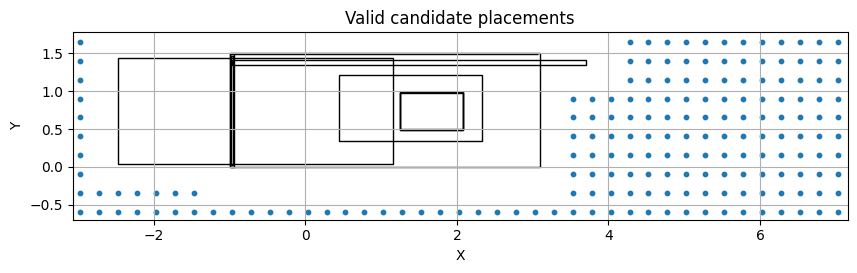

Wrote: outputs\scene_graph.json
Room bounds: {'min': [-3.072100089727104, -0.6975192089530289, -3.644868236094374], 'max': [7.158818006515503, 1.7766119499656021, 1.0000006481999293]}
Floor z: -1.734517626987245
Objects: 84
Tag COunts: Counter({'clutter': 71, 'obstacle': 10, 'structure': 3})


In [31]:
if __name__ == "__main__":
    glb_path = "living_room.glb"
    out_path = os.path.join("outputs", "scene_graph.json")
    main(glb_path, out_path)